# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures import compute_firing_rate
from spiketools.spatial.occupancy import compute_occupancy
from spiketools.plts.data import plot_bar, plot_hist, plot_lines
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import _add_hlines, _add_vlines
from spiketools.utils.timestamps import convert_sec_to_min
from spiketools.utils.extract import get_range, get_value_by_time, get_values_by_time_range
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.utils.data import compute_range
from spiketools.utils.base import count_elements

In [3]:
import sys
sys.path.append('../code')
from plts import plot_task_structure

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/NWB')
#data_folder = Path('/scratch/tom.donoghue/TH/NWB')

In [6]:
# # Define task & subject information
# session = {
#     'task' : 'THF',
#     'subject' : 'wv003',
#     'session' : 0
# }

In [7]:
# Define subject information
session = {
    'task' : 'THF',
    'subject' : 'wv002',
    'session' : 1    
}

In [8]:
# Define bins to use
#bins = [7, 21]
bins = [6, 10]

In [9]:
# Define occupancy related settings
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

## Load NWB Data

In [10]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [11]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x140490188525776
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    heading <class 'pynwb.behavior.CompassDirection'>,
    position <class 'pynwb.behavior.Position'>,
    recall <class 'pynwb.behavior.Position'>,
    stimuli <class 'pynwb.behavior.Position'>
  }
  data_collection: West Virginia
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Task: TH1 build-2.102 (English)
  experimenter: ['Thomas Donoghue' 'Cameron Holman' 'Runnan Cao']
  file_create_date: [datetime.datetime(2022, 4, 24, 23, 43, 6, 834506, tzinfo=tzoffset(None, -14400))]
  identifier: p18WV_CelebA_S3_NavFace_S2
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": 

## Task Structure

In the following, shadings are:
- green is encoding (navigation)
- yellow is the distractor task
- purple is recall (using the selector)

In [12]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 8


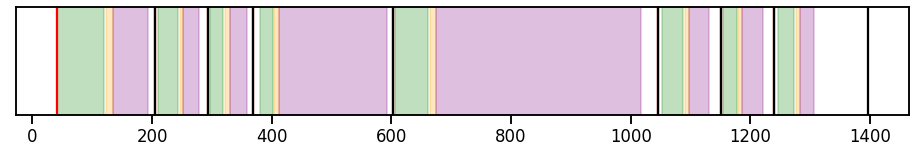

In [13]:
# Plot the task structure for the whole recording
plot_task_structure(nwbfile.trials)

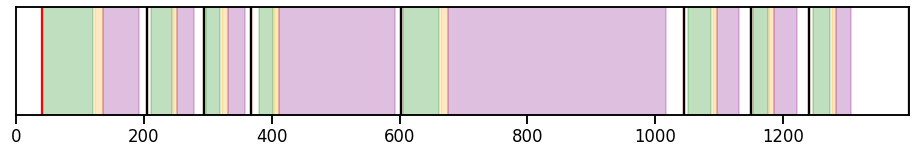

In [14]:
# Plot the task structure for a single block
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[7]])

## Position Data

In [15]:
# Extract the position data
pos = nwbfile.acquisition['position']['player_position']
pos

player_position pynwb.behavior.SpatialSeries at 0x140490190546160
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (10685, 2), type "<f8">
  description: Position of the subject in the arena.
  interval: 1
  reference_frame: corner
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (10685,), type "<f8">
  timestamps_unit: seconds
  unit: virtual units

#### Plot all position data

This includes self-navigation, and transport.

In [16]:
# Extract position timestamps and values
ptimes = pos.timestamps[:]
positions = pos.data[:].T

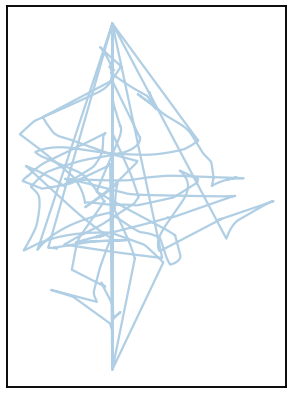

In [17]:
# Plot the map across all position traces
plot_positions(positions, figsize=(5, 7))

#### Select navigation only from navigation

In [18]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

In [19]:
# Epoch position data to self-navigation
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)

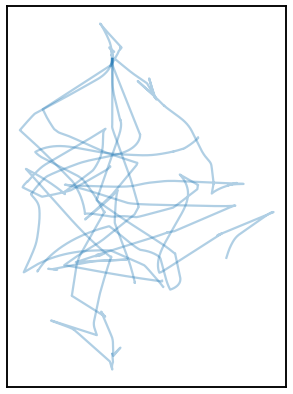

In [20]:
# Plot navigation-trial level position data
plot_positions(positions_trials, figsize=(5, 7))

In [21]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

In [22]:
# Check position ranges & compare to boundaries
print('X data range: \t{:6.2f} - {:6.2f}'.format(*compute_range(positions[0, :])))
print('Z data range: \t{:6.2f} - {:6.2f}'.format(*compute_range(positions[1, :])))
print()
print('X boundary: \t{:6.2f} - {:6.2f}'.format(*x_boundary))
print('Z boundary: \t{:6.2f} - {:6.2f}'.format(*z_boundary))

X data range: 	365.08 - 418.59
Z data range: 	285.00 - 433.00

X boundary: 	349.85 - 419.85
Z boundary: 	293.00 - 424.34


In [23]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]

#### Check speed

In [24]:
# Get speed
speed = nwbfile.processing['position_measures']['speed'].data[:]

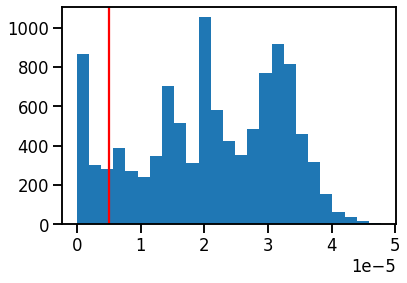

In [25]:
# Plot the histogram of speed values, and compare to threshold
plot_hist(speed, bins=25)
_add_vlines(speed_thresh, color='red')

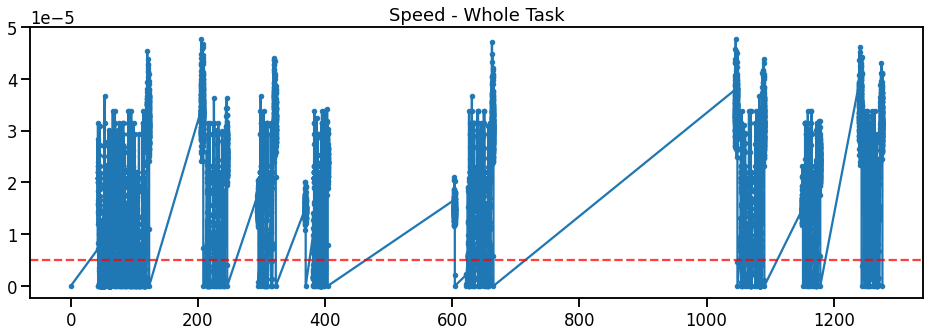

In [26]:
# Plot the speed across the whole task
plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task', figsize=(16, 5))
_add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

In [27]:
# Extract speed across a single navigation period (trial)
t_ind = 5
t_times, t_speed = get_values_by_time_range(
    ptimes, speed, nwbfile.trials.navigation_start[t_ind], nwbfile.trials.navigation_stop[t_ind])

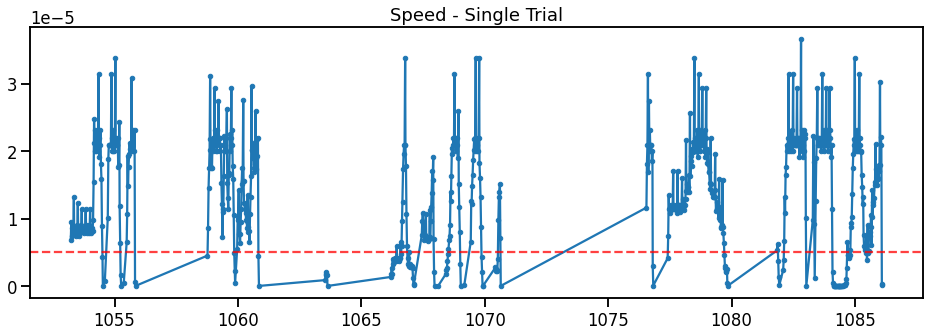

In [28]:
# Plot the speed across a single navigation session (one trial)
plot_lines(t_times, t_speed, marker='.', title='Speed - Single Trial', figsize=(16, 5))
_add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

#### Check position samples from across navigation

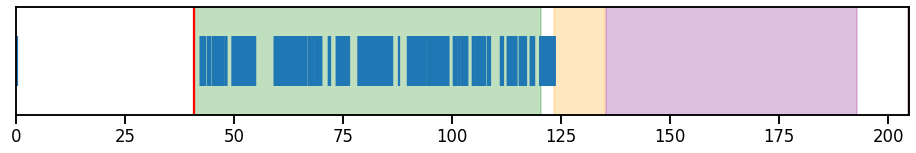

In [29]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials,
                    data_points=get_range(ptimes, 0, nwbfile.trials.stop_time[0]),
                    xlim=[0, nwbfile.trials.stop_time[0]])

## Occupancy

In [30]:
# Collect settings for occupancy
occ_kwargs = {'time_threshold' : time_thresh, 'minimum' : min_occ,
              'normalize' : False, 'set_nan' : True}

In [31]:
# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, **occ_kwargs)

/Users/tom/opt/anaconda3/envs/spike/lib/python3.8/site-packages/spiketools/utils/checks.py:102: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn('The data values extend beyond the given bin definition.')


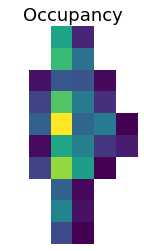

In [32]:
# Plot the occupancy
plot_heatmap(occ, title="Occupancy", figsize=(5, 4))

## Stimuli

In [33]:
# Collect chest positions
chest_pos = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T

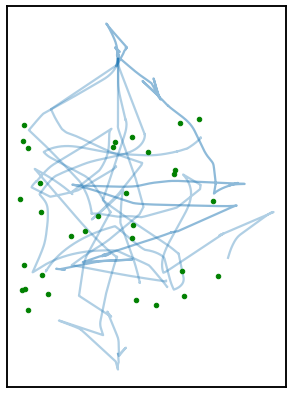

In [34]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions_trials, alpha=0.5, figsize=(5, 7),
               landmarks={'positions' : chest_pos, 'color' : 'green'})

In [35]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.trials.chest_trials[:]
chest_trials

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7])

### Trial-by-Trial

In the following representation:
- purple dots are the trial start location
- orange dots are the trial end location (where they do recall from)
- green dots are the chest locations

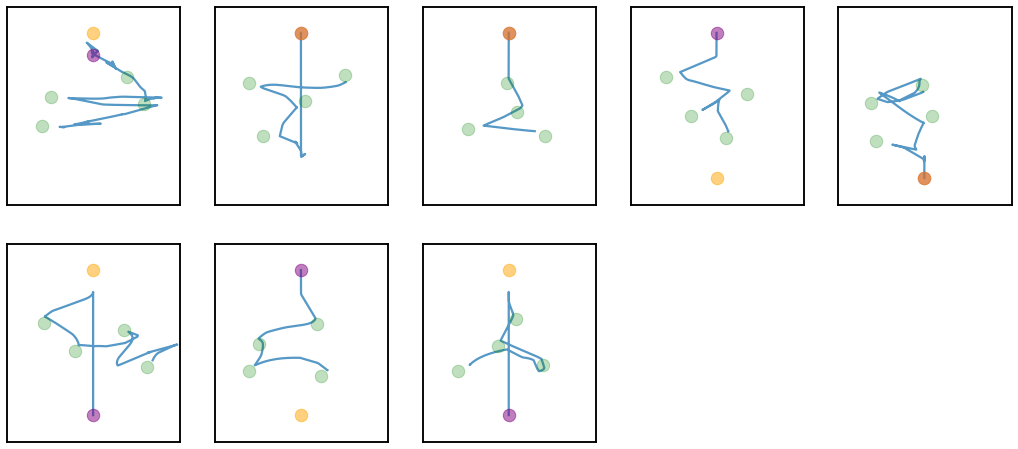

In [36]:
# TODO: this should be able to be updated with `plot_trial_position`
# Plot the trajectories for each trial
for t_ind, ax in zip(range(n_trials), make_axes(n_trials)):

    t_st = nwbfile.trials['start_time'][t_ind]
    ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
    t_en = nwbfile.trials['stop_time'][t_ind]
    last_ch = ch_openings[-1]

    # Plot the position traces
    t_time, t_pos = get_values_by_time_range(ptimes, positions, t_st, last_ch)
    plot_positions(t_pos, alpha=0.75, ax=ax)

    # Plot the trial start position (purple)
    ax.plot(*t_pos[:, 0], '.', color='purple', ms=25, alpha=0.5)

    # Plot the trial end position
    end_point = get_value_by_time(ptimes, positions, t_en)
    ax.plot(*end_point, '.', color='orange', ms=25, alpha=0.5)

    # Plot the chest locations
    t_mask = chest_trials == t_ind
    ax.plot(chest_pos[0, t_mask], chest_pos[1, t_mask], '.g', ms=25, alpha=0.25)

    # Set x & y limits to the terrain range, expanding z to include the towers
    ax.set_xlim(*x_boundary)
    ax.set_ylim(z_boundary[0]-35, z_boundary[1]+35)

### Recall Selector

In [37]:
# Get the position traces of the recall selector
recall_pos = nwbfile.acquisition['recall']['selector'].data[:].T

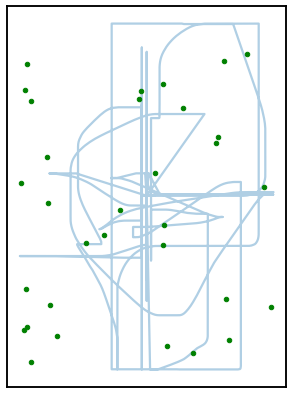

In [38]:
# Plot the positions of the recall selector, overlaid with chest positions
landmarks = {'positions' : chest_pos, 'color' : 'g'}
plot_positions(recall_pos, landmarks=landmarks, figsize=(5, 7))

## Trials

In [39]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x140490190545008
Fields:
  colnames: ['start_time' 'stop_time' 'chest_opening_time' 'chest_recall_start'
 'chest_recall_stop' 'chest_rotation_start' 'chest_rotation_stop'
 'chest_trials' 'confidence_prompt_time' 'confidence_response'
 'confidence_response_time' 'correct' 'distractor_correct'
 'distractor_start' 'distractor_stop' 'error' 'feedback_start'
 'feedback_stop' 'full_chest' 'homebase_transport_start'
 'homebase_transport_stop' 'n_chests' 'n_treasures' 'navigation_start'
 'navigation_stop' 'recall_start' 'recall_stop' 'recall_trials'
 'response_time' 'scorescreen_start' 'scorescreen_stop' 'stimulus'
 'tower_transport_start' 'tower_transport_stop']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    chest_opening_time_index <class 'hdmf.common.table.VectorIndex'>,
    chest_opening_time <class 'hdmf.common.table.VectorData'>,
    chest_recall_start_index <class 'hdmf.co

In [40]:
# Check event names
event_names = nwbfile.trials.colnames
print(event_names)

('start_time', 'stop_time', 'chest_opening_time', 'chest_recall_start', 'chest_recall_stop', 'chest_rotation_start', 'chest_rotation_stop', 'chest_trials', 'confidence_prompt_time', 'confidence_response', 'confidence_response_time', 'correct', 'distractor_correct', 'distractor_start', 'distractor_stop', 'error', 'feedback_start', 'feedback_stop', 'full_chest', 'homebase_transport_start', 'homebase_transport_stop', 'n_chests', 'n_treasures', 'navigation_start', 'navigation_stop', 'recall_start', 'recall_stop', 'recall_trials', 'response_time', 'scorescreen_start', 'scorescreen_stop', 'stimulus', 'tower_transport_start', 'tower_transport_stop')


In [41]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 8


In [42]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,chest_opening_time,chest_recall_start,chest_recall_stop,chest_rotation_start,chest_rotation_stop,chest_trials,confidence_prompt_time,confidence_response,...,navigation_stop,recall_start,recall_stop,recall_trials,response_time,scorescreen_start,scorescreen_stop,stimulus,tower_transport_start,tower_transport_stop
id,,,,,,,,,,,,,,,,,,,,,
0,40.664429,204.766159,"[70.05673837661743, 76.4848062992096, 86.21890...","[152.40160655975342, 158.66967272758484]","[155.40663838386536, 192.56603002548218]","[69.854736328125, 76.2338035106659, 86.0579071...","[70.05473852157593, 76.4848062992096, 86.21890...","[0, 0, 0, 0]","[135.24542570114136, 155.5666401386261]","[maybe, maybe]",...,120.281268,135.244426,192.726032,"[0, 0]","[155.20663619041443, 192.3650279045105]",202.821138,204.766159,"[Face_44, Face_50]",120.281268,123.371300
1,204.773159,293.707096,"[220.3673231601715, 226.0683832168579, 232.525...","[260.54674673080444, 267.5048198699951]","[263.5807785987854, 278.60593724250793]","[219.11731004714966, 225.83938074111938, 232.4...","[220.3673231601715, 226.0683832168579, 232.525...","[1, 1, 1, 1]","[252.36066031455994, 263.7267801761627]","[yes, yes]",...,244.043573,252.360660,278.800939,"[1, 1]","[263.3797764778137, 278.4049348831177]",292.888088,293.707096,"[Face_48, Face_45]",244.043573,246.153595
2,293.715096,368.055880,"[299.3251554965973, 304.1852066516876, 309.878...","[347.57266426086426, 354.6557385921478]","[351.1617021560669, 358.4877791404724]","[299.1591536998749, 303.38019824028015, 309.19...","[299.3251554965973, 304.1852066516876, 309.878...","[2, 2, 2, 2]","[330.9644889831543, 351.3427038192749]","[maybe, maybe]",...,319.341367,330.964489,358.598780,"[2, 2]","[350.96069979667664, 358.28677701950073]",367.110870,368.055880,"[Face_16, Face_22]",319.341367,322.521400
3,368.061880,602.595353,"[383.69204473495483, 390.6771185398102, 395.51...","[418.91341614723206, 589.0072093009949]","[423.6974666118622, 592.1522426605225]","[383.6020438671112, 390.6611182689667, 395.419...","[383.69204473495483, 390.6771185398102, 395.51...","[3, 3, 3, 3]","[411.7763409614563, 423.89146852493286]","[no, maybe]",...,402.258241,411.775341,592.243243,"[3, 3]","[423.4964644908905, 591.9512403011322]",601.547342,602.595353,"[Face_14, Face_13]",402.258241,404.250262
4,602.602353,1044.868015,"[629.1796329021454, 634.811692237854, 650.5038...","[990.294439792633, 996.7025074958801, 1010.887...","[995.0364899635315, 1000.4935474395752, 1016.9...","[629.0906319618225, 634.4296882152557, 650.446...","[629.1796329021454, 634.811692237854, 650.5038...","[4, 4, 4, 4]","[675.3381195068359, 995.2024915218353, 1000.60...","[no, yes, yes]",...,661.986979,675.338120,1017.017722,"[4, 4, 4]","[994.8354876041412, 1000.2925453186035, 1016.7...",1040.450969,1044.868015,"[Face_27, Face_2, Face_26]",661.986979,664.875009


#### Confidence

In [43]:
# Count confidence answers
conf_counts = count_elements(nwbfile.trials.confidence_response.data[:],
                             labels=['yes', 'maybe', 'no'])

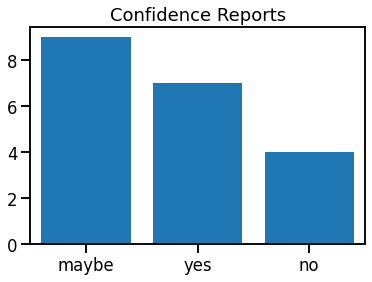

In [44]:
# Plot confidence answers
plot_bar(conf_counts.values(), labels=conf_counts.keys(), title='Confidence Reports')

#### Response Error

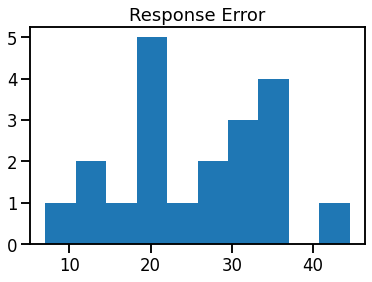

In [45]:
# Plot response error
plot_hist(nwbfile.trials.error.data[:], title='Response Error')

## Check Unit Data

Note that we only look at units that are marked to keep.

In [46]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x140490190589904
Fields:
  colnames: ['channel' 'cluster' 'keep' 'location' 'wvID' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    cluster <class 'hdmf.common.table.VectorData'>,
    keep <class 'hdmf.common.table.VectorData'>,
    location <class 'hdmf.common.table.VectorData'>,
    wvID <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with oSort by Runnan Cao.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [47]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 64


In [48]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 100625


In [49]:
# Count the number of units per wire
channel_counts = count_elements(nwbfile.units.channel[:])
counts_per_wire = count_elements(channel_counts.values(), labels='count', sort=True)

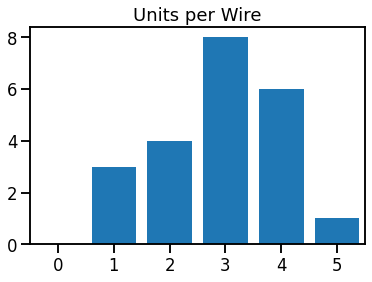

In [50]:
# Plot the distribution of units per wire
plot_bar(counts_per_wire.values(), labels=counts_per_wire.keys(), title='Units per Wire')

#### Check Keep & Reject Neurons

In [51]:
# Check how many units are marked to keep
n_keep = sum(nwbfile.units.keep[:])
print('Number of keep neurons: {}'.format(n_keep))

Number of keep neurons: 54


In [52]:
# Get the indices of the neurons to keep
keep_inds = np.where(nwbfile.units.keep[:])[0]
assert len(keep_inds) == n_keep

In [53]:
# Get the indices of the neurons that are rejected
reject_inds = np.where((nwbfile.units.keep[:] - 1) * -1)[0]
assert len(reject_inds) + n_keep == n_units

In [54]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(nwbfile.units.get_unit_spike_times(s_ind)) \
         for s_ind in keep_inds]

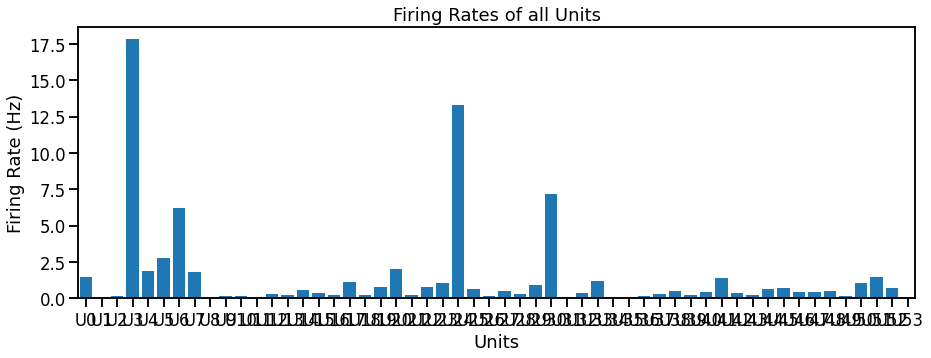

In [55]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

In [56]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in keep_inds]

In [57]:
# Set start and stop time of the task (note that 0 is task start time)
st = 0
en = nwbfile.trials.stop_time[-1]

In [58]:
# Compute the task length, in minutes
task_len = convert_sec_to_min(en)

In [59]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 23.29 minutes


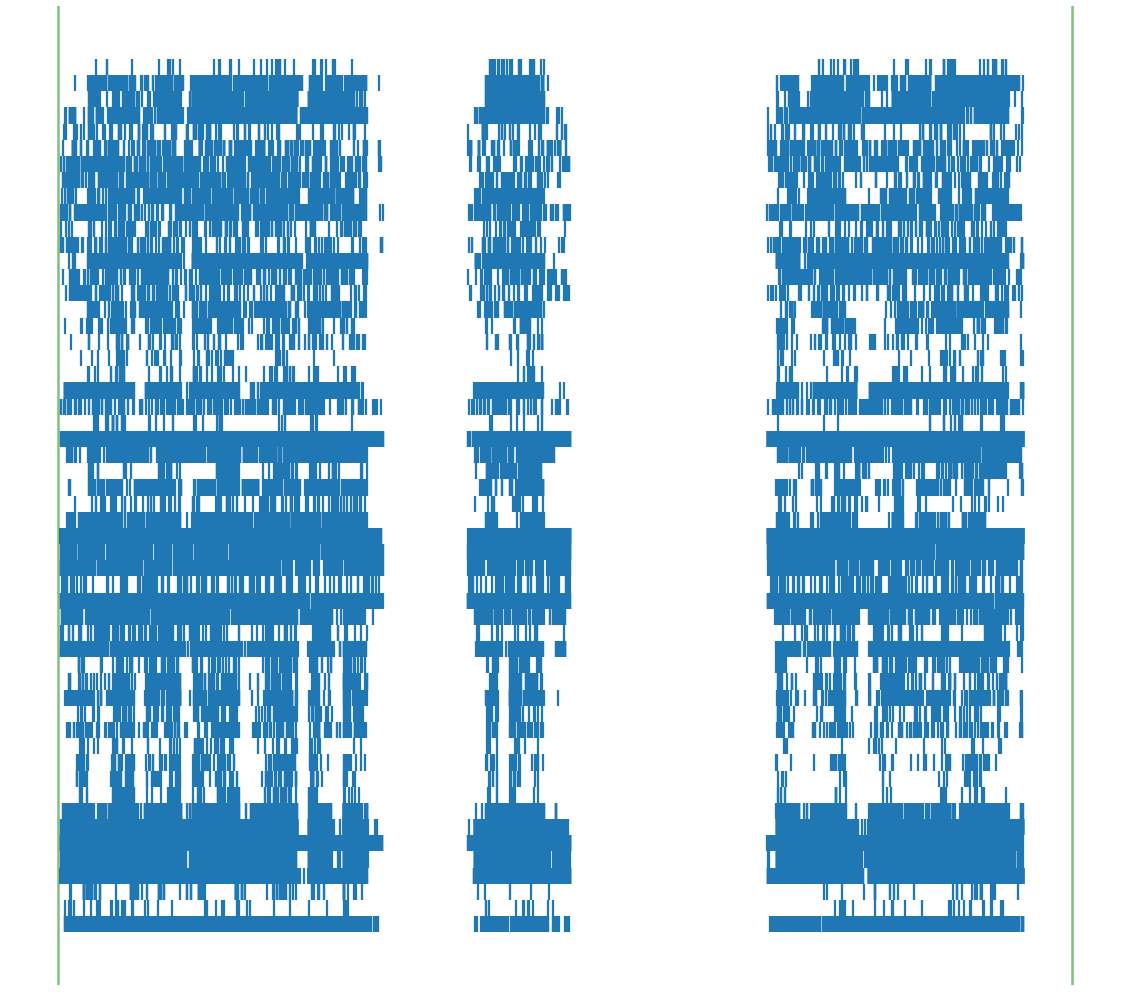

In [60]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

In [61]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in keep_inds:
#     spikes = nwbfile.units.get_unit_spike_times(uind)
#     plot_rasters(spikes, show_axis=True, figsize=(16, 2))